In [80]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Pre-process dataset

In [81]:
df = pd.read_csv('../00_dataset/YelpZip/metadata', 
                 sep='\t',
                 header=None,
                 names=["user_id", "prod_id", "rating", "label", "date"])
df

,user_id,prod_id,rating,label,date
0,5044,0,1.0,-1,2014-11-16
1,5045,0,1.0,-1,2014-09-08
2,5046,0,3.0,-1,2013-10-06
3,5047,0,5.0,-1,2014-11-30
4,5048,0,5.0,-1,2014-08-28
...,...,...,...,...,...
608593,119664,5039,4.0,1,2013-01-20
608594,56277,5039,2.0,1,2012-11-12
608595,265320,5039,1.0,1,2012-08-22
608596,161722,5039,4.0,1,2011-05-11


In [82]:
# Check for Null values
df.isnull().sum()

user_id    0
prod_id    0
rating     0
label      0
date       0
dtype: int64

In [83]:
# Check the num of positive and negative rows


In [84]:
# Equalise 1 and -1 labels, only 8000 rows per label
positive_df = df[(df['label'] == 1)][:8000]
negative_df = df[(df['label'] == -1)][:8000]
negative_df["label"] = 0
dataset_df = pd.concat([positive_df, negative_df])
dataset_df

,user_id,prod_id,rating,label,date
7,5051,0,1.0,1,2014-12-05
8,5052,0,2.0,1,2014-11-26
9,5053,0,4.0,1,2014-11-17
10,5054,0,3.0,1,2014-10-20
11,5055,0,5.0,1,2014-10-13
...,...,...,...,...,...
55969,48392,496,5.0,0,2008-06-18
55970,48393,496,5.0,0,2008-06-11
55971,48394,496,5.0,0,2008-03-28
55972,48395,496,5.0,0,2008-03-22


# Create Train-test split

In [85]:
y = dataset_df['label']
X = dataset_df.drop('label', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Without Feature Engineering

In [86]:
noFE_train, noFE_test = X_train.copy(), X_test.copy()
noFE_train['date'] = pd.to_datetime(noFE_train['date']).astype('int64') // 10**9
noFE_test['date'] = pd.to_datetime(noFE_test['date']).astype('int64') // 10**9

noFE_train = noFE_train.drop(columns=["user_id", "prod_id"], errors="ignore")
noFE_test = noFE_test.drop(columns=["user_id", "prod_id"], errors="ignore")

from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report


xgclf = XGBClassifier(scale_pos_weight=len(y_train[y_train == 0]) / len(y_train[y_train == 1]))
xgclf.fit(noFE_train, y_train)
y_pred = xgclf.predict(noFE_test)
# Evaluate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='binary')  # Use 'macro' or 'weighted' for multiclass
recall = recall_score(y_test, y_pred, average='binary')
f1 = f1_score(y_test, y_pred, average='binary')
conf_matrix = confusion_matrix(y_test, y_pred)

# Print results
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print("\nConfusion Matrix:")
print(conf_matrix)

# Detailed classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.5802
Precision: 0.5828
Recall: 0.5646
F1 Score: 0.5735

Confusion Matrix:
[[1430  970]
 [1045 1355]]

Classification Report:
              precision    recall  f1-score   support

           0       0.58      0.60      0.59      2400
           1       0.58      0.56      0.57      2400

    accuracy                           0.58      4800
   macro avg       0.58      0.58      0.58      4800
weighted avg       0.58      0.58      0.58      4800



# Import Feature Engineer functions

In [87]:
from UserFeatureEngineering import UserEngineer
from RestaurantFeatureEngineering import RestaurantEngineer

userFeatureEngineer = UserEngineer(X_train)
restaurantFeatureEngineer = RestaurantEngineer(X_train)

# Apply feature engineering to train set

In [88]:
# Create the features and merge them with original dataset
user_features_train = userFeatureEngineer.aggregateTrainFeatures()
res_features_train = restaurantFeatureEngineer.aggregateTrainFeatures()

new_X_train = X_train.merge(res_features_train, on='prod_id', how='left').merge(user_features_train, on='user_id', how='left')

# Convert date to seconds
new_X_train['date'] = pd.to_datetime(new_X_train['date']).astype('int64') // 10**9
new_X_train

,user_id,prod_id,rating,date,total_reviews_for_restaurant,avg_rating_for_restaurant,std_dev_rating_for_restaurant,median_rating_for_restaurant,review_frequency_for_restaurant,extreme_rating_index,...,rating_mean,rating_min,rating_max,rating_std,user_earliest,user_latest,user_days_active,user_review_timespan,users_avg_per_day,user_active_percentage
0,10985,48,2.0,1395446400,34,3.764706,1.393901,4.0,8.764706,1.470588,...,2.0,2.0,2.0,0.0,1395446400,1395446400,1,1,1.0,1.0
1,6866,9,2.0,1382572800,1745,2.534097,1.322490,2.0,2.014900,1.184527,...,2.0,2.0,2.0,0.0,1382572800,1382572800,1,1,1.0,1.0
2,46383,477,5.0,1301702400,15,3.666667,1.676163,5.0,109.733333,1.600000,...,5.0,5.0,5.0,0.0,1301702400,1301702400,1,1,1.0,1.0
3,13294,414,4.0,1380672000,110,3.954545,1.383960,5.0,7.427273,1.536364,...,4.0,4.0,4.0,0.0,1380672000,1380672000,1,1,1.0,1.0
4,29561,214,4.0,1363824000,2,4.500000,0.707107,4.5,297.000000,1.500000,...,4.0,4.0,4.0,0.0,1363824000,1363824000,1,1,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11195,26867,176,2.0,1341792000,15,4.066667,1.162919,5.0,69.666667,1.333333,...,2.0,2.0,2.0,0.0,1341792000,1341792000,1,1,1.0,1.0
11196,9051,1662,3.0,1390521600,76,4.000000,1.356466,5.0,6.263158,1.500000,...,3.0,3.0,3.0,0.0,1390521600,1390521600,1,1,1.0,1.0
11197,26545,168,5.0,1415145600,9,4.555556,1.013794,5.0,4.555556,1.777778,...,5.0,5.0,5.0,0.0,1415145600,1415145600,1,1,1.0,1.0
11198,8239,28,4.0,1161043200,583,4.080617,1.046358,4.0,6.053173,1.334477,...,4.0,4.0,4.0,0.0,1161043200,1161043200,1,1,1.0,1.0


# Apply feature engineering to test set
### ...sequentially

In [89]:
new_X_test = restaurantFeatureEngineer.updateTestRestaurants(X_test)
new_X_test = userFeatureEngineer.updateTestUsers(new_X_test)
new_X_test

,user_id,prod_id,rating,date,total_reviews_for_restaurant,avg_rating_for_restaurant,std_dev_rating_for_restaurant,median_rating_for_restaurant,review_frequency_for_restaurant,extreme_rating_index,...,rating_mean,rating_min,rating_max,rating_std,user_earliest,user_latest,user_days_active,user_review_timespan,users_avg_per_day,user_active_percentage
0,11144,3345,2.0,1393200000,159,3.779874,1.266150,4.0,3.031447,1.295597,...,3.0,3.0,3.0,0.000,1393200000,1393200000,0,1,0.000,0.000
1,34407,3105,3.0,1177027200,6,2.833333,2.041241,2.5,207.500000,1.833333,...,3.0,3.0,3.0,0.000,1177027200,1177027200,0,1,0.000,0.000
2,6336,9,1.0,1420329600,1745,2.534097,1.322490,2.0,2.014900,1.184527,...,3.0,3.0,3.0,0.000,1420329600,1420329600,0,1,0.000,0.000
3,10390,34,5.0,1419033600,17,4.647059,0.606339,5.0,23.588235,1.647059,...,3.0,3.0,3.0,0.000,1419033600,1419033600,0,1,0.000,0.000
4,11727,57,3.0,1353542400,705,3.617021,1.021499,4.0,4.120567,0.968794,...,3.0,3.0,3.0,0.000,1353542400,1353542400,0,1,0.000,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4795,12428,59,5.0,1390003200,585,4.268376,0.940767,5.0,6.041026,1.432479,...,3.0,3.0,3.0,0.000,1390003200,1390003200,0,1,0.000,0.000
4796,14378,3839,5.0,1331769600,32,3.062500,1.584960,3.5,74.187500,1.437500,...,3.0,3.0,3.0,0.000,1331769600,1331769600,0,1,0.000,0.000
4797,30327,237,5.0,1304553600,38,3.500000,1.520135,4.0,58.815789,1.447368,...,3.0,3.0,3.0,0.000,1304553600,1304553600,0,1,0.000,0.000
4798,11713,57,4.0,1358467200,705,3.617021,1.021499,4.0,4.120567,0.968794,...,3.0,3.0,3.0,0.000,1358467200,1358467200,0,1,0.000,0.000


In [90]:
new_X_train = new_X_train.drop(columns=["user_id", "prod_id"], errors="ignore")
new_X_test = new_X_test.drop(columns=["user_id", "prod_id"], errors="ignore")

print(new_X_train.shape, new_X_test.shape)

(11200, 19) (4800, 19)


In [91]:
new_X_train.dtypes

rating                             float64
date                                 int64
total_reviews_for_restaurant         int64
avg_rating_for_restaurant          float64
std_dev_rating_for_restaurant      float64
median_rating_for_restaurant       float64
review_frequency_for_restaurant    float64
extreme_rating_index               float64
user_restaurants_reviewed            int64
rating_mean                        float64
rating_min                         float64
rating_max                         float64
rating_std                         float64
user_earliest                        int64
user_latest                          int64
user_days_active                     int64
user_review_timespan                 int64
users_avg_per_day                  float64
user_active_percentage             float64
dtype: object

In [92]:
new_X_test.dtypes

rating                             float64
date                                 int64
total_reviews_for_restaurant         int32
avg_rating_for_restaurant          float64
std_dev_rating_for_restaurant      float64
median_rating_for_restaurant       float64
review_frequency_for_restaurant    float64
extreme_rating_index               float64
user_restaurants_reviewed            int32
rating_mean                        float64
rating_min                         float64
rating_max                         float64
rating_std                         float64
user_earliest                        int32
user_latest                          int32
user_days_active                     int32
user_review_timespan                 int32
users_avg_per_day                  float64
user_active_percentage             float64
dtype: object

In [93]:
new_X_train.isnull().sum()

rating                             0
date                               0
total_reviews_for_restaurant       0
avg_rating_for_restaurant          0
std_dev_rating_for_restaurant      0
median_rating_for_restaurant       0
review_frequency_for_restaurant    0
extreme_rating_index               0
user_restaurants_reviewed          0
rating_mean                        0
rating_min                         0
rating_max                         0
rating_std                         0
user_earliest                      0
user_latest                        0
user_days_active                   0
user_review_timespan               0
users_avg_per_day                  0
user_active_percentage             0
dtype: int64

In [94]:
new_X_test.isnull().sum()

rating                             0
date                               0
total_reviews_for_restaurant       0
avg_rating_for_restaurant          0
std_dev_rating_for_restaurant      0
median_rating_for_restaurant       0
review_frequency_for_restaurant    0
extreme_rating_index               0
user_restaurants_reviewed          0
rating_mean                        0
rating_min                         0
rating_max                         0
rating_std                         0
user_earliest                      0
user_latest                        0
user_days_active                   0
user_review_timespan               0
users_avg_per_day                  0
user_active_percentage             0
dtype: int64

# Feature Scaling (StandardScaler)

In [ ]:
#TODO

# PCA

In [ ]:
#TODO
from sklearn.decomposition import PCA

# pca = PCA(n_components=11)
# new_X_train = pca.fit_transform(new_X_train)
# new_X_test = pca.transform(new_X_test)

# Train model

In [97]:
# LOGISTIC REGRESSION MODEL

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

# Train logistic regression model
clf = LogisticRegression()
clf.fit(new_X_train, y_train)

# Make predictions
y_pred = clf.predict(new_X_test)

# Evaluate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='binary')  # Use 'macro' or 'weighted' for multiclass
recall = recall_score(y_test, y_pred, average='binary')
f1 = f1_score(y_test, y_pred, average='binary')
conf_matrix = confusion_matrix(y_test, y_pred)

# Print results
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print("\nConfusion Matrix:")
print(conf_matrix)

# Detailed classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.7654
Precision: 0.7206
Recall: 0.8671
F1 Score: 0.7871

Confusion Matrix:
[[1593  807]
 [ 319 2081]]

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.66      0.74      2400
           1       0.72      0.87      0.79      2400

    accuracy                           0.77      4800
   macro avg       0.78      0.77      0.76      4800
weighted avg       0.78      0.77      0.76      4800



c:\Users\cryst\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [98]:
# RANDOM FOREST CLASSIFIER
from sklearn.ensemble import RandomForestClassifier

rfclf = RandomForestClassifier(class_weight="balanced", random_state=42)
rfclf.fit(new_X_train, y_train)
y_pred = rfclf.predict(new_X_test)

# Evaluate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='binary')  # Use 'macro' or 'weighted' for multiclass
recall = recall_score(y_test, y_pred, average='binary')
f1 = f1_score(y_test, y_pred, average='binary')
conf_matrix = confusion_matrix(y_test, y_pred)

# Print results
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print("\nConfusion Matrix:")
print(conf_matrix)

# Detailed classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))



Accuracy: 0.8006
Precision: 0.7365
Recall: 0.9363
F1 Score: 0.8244

Confusion Matrix:
[[1596  804]
 [ 153 2247]]

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.67      0.77      2400
           1       0.74      0.94      0.82      2400

    accuracy                           0.80      4800
   macro avg       0.82      0.80      0.80      4800
weighted avg       0.82      0.80      0.80      4800



In [ ]:
!pip install xgboost

In [ ]:
# XGBOOST
from xgboost import XGBClassifier

xgclf = XGBClassifier(scale_pos_weight=len(y_train[y_train == 0]) / len(y_train[y_train == 1]))
xgclf.fit(new_X_train, y_train)
y_pred = xgclf.predict(new_X_test)
# Evaluate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='binary')  # Use 'macro' or 'weighted' for multiclass
recall = recall_score(y_test, y_pred, average='binary')
f1 = f1_score(y_test, y_pred, average='binary')
conf_matrix = confusion_matrix(y_test, y_pred)

# Print results
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print("\nConfusion Matrix:")
print(conf_matrix)

# Detailed classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))



Accuracy: 0.7529
Precision: 0.6765
Recall: 0.9696
F1 Score: 0.7969

Confusion Matrix:
[[1287 1113]
 [  73 2327]]

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.54      0.68      2400
           1       0.68      0.97      0.80      2400

    accuracy                           0.75      4800
   macro avg       0.81      0.75      0.74      4800
weighted avg       0.81      0.75      0.74      4800



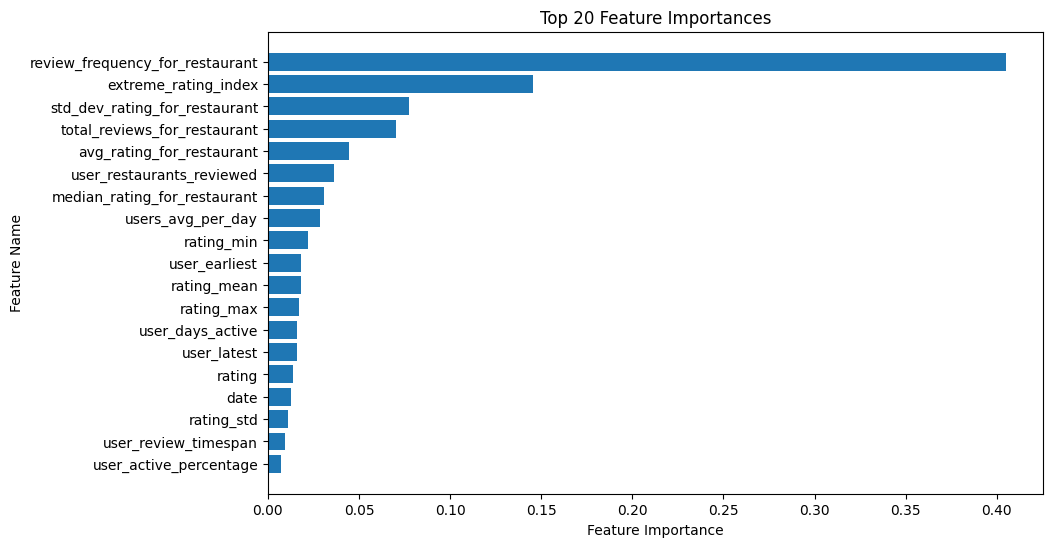

,Feature,Importance
6,review_frequency_for_restaurant,0.405073
7,extreme_rating_index,0.145505
4,std_dev_rating_for_restaurant,0.077561
2,total_reviews_for_restaurant,0.070082
3,avg_rating_for_restaurant,0.044499
8,user_restaurants_reviewed,0.036341
5,median_rating_for_restaurant,0.030550
17,users_avg_per_day,0.028624
10,rating_min,0.022102
13,user_earliest,0.018337


In [ ]:
import xgboost as xgb
import pandas as pd
import matplotlib.pyplot as plt

# Train XGBoost model
xgclf = xgb.XGBClassifier(scale_pos_weight=len(y_train[y_train == 0]) / len(y_train[y_train == 1]))
xgclf.fit(new_X_train, y_train)

# Get feature importance
feature_importance = xgclf.feature_importances_
feature_names = new_X_train.columns

# Convert to DataFrame
feat_imp_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})
feat_imp_df = feat_imp_df.sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(feat_imp_df['Feature'][:20], feat_imp_df['Importance'][:20])
plt.xlabel('Feature Importance')
plt.ylabel('Feature Name')
plt.title('Top 20 Feature Importances')
plt.gca().invert_yaxis()
plt.show()

# Display the top features
feat_imp_df.head(20)

In [ ]:
# checking versions (sync with kaggle if using)
import sys
import numpy as np
import pandas as pd
import sklearn

print("Python Version:", sys.version)
print("NumPy Version:", np.__version__)
print("Pandas Version:", pd.__version__)
print("Scikit-Learn Version:", sklearn.__version__)

Python Version: 3.12.0 (tags/v3.12.0:0fb18b0, Oct  2 2023, 13:03:39) [MSC v.1935 64 bit (AMD64)]
NumPy Version: 1.26.3
Pandas Version: 2.2.1
Scikit-Learn Version: 1.5.0
